# Instructions
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free Cloud TPU</h3>
 
   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   2. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Download the source code
Download the source code of the Mask R-CNN model.

In [0]:
!git clone https://github.com/tensorflow/tpu/

In [0]:
!git clone https://github.com/titu1994/Neural-Style-Transfer.git

## Import libraries

In [0]:
from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils
import matplotlib.pyplot as plt

## Load the COCO index mapping
This Colab uses a pretrained checkpoint of the Mask R-CNN model that is trained using the COCO dataset. Here is the mapping between the indices that the model predicts and the categories in text.

In [0]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}


## Load an image
Now, you can load an image. Use either the sample image included here, or update the field with an image of your choice.

--2020-01-25 07:22:32--  https://cdn.shopify.com/s/files/1/0438/1069/products/TheCitizenry_HolidayTabletop_2018-9610_145d74eb-576f-47d1-b208-4813965c5fe3_1024x1024.jpg?v=1541514971
Resolving cdn.shopify.com (cdn.shopify.com)... 23.35.200.72, 2600:1407:1d:498::39b, 2600:1407:1d:496::39b
Connecting to cdn.shopify.com (cdn.shopify.com)|23.35.200.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35986 (35K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  35.14K  --.-KB/s    in 0.02s   

2020-01-25 07:22:32 (1.72 MB/s) - ‘test.jpg’ saved [35986/35986]



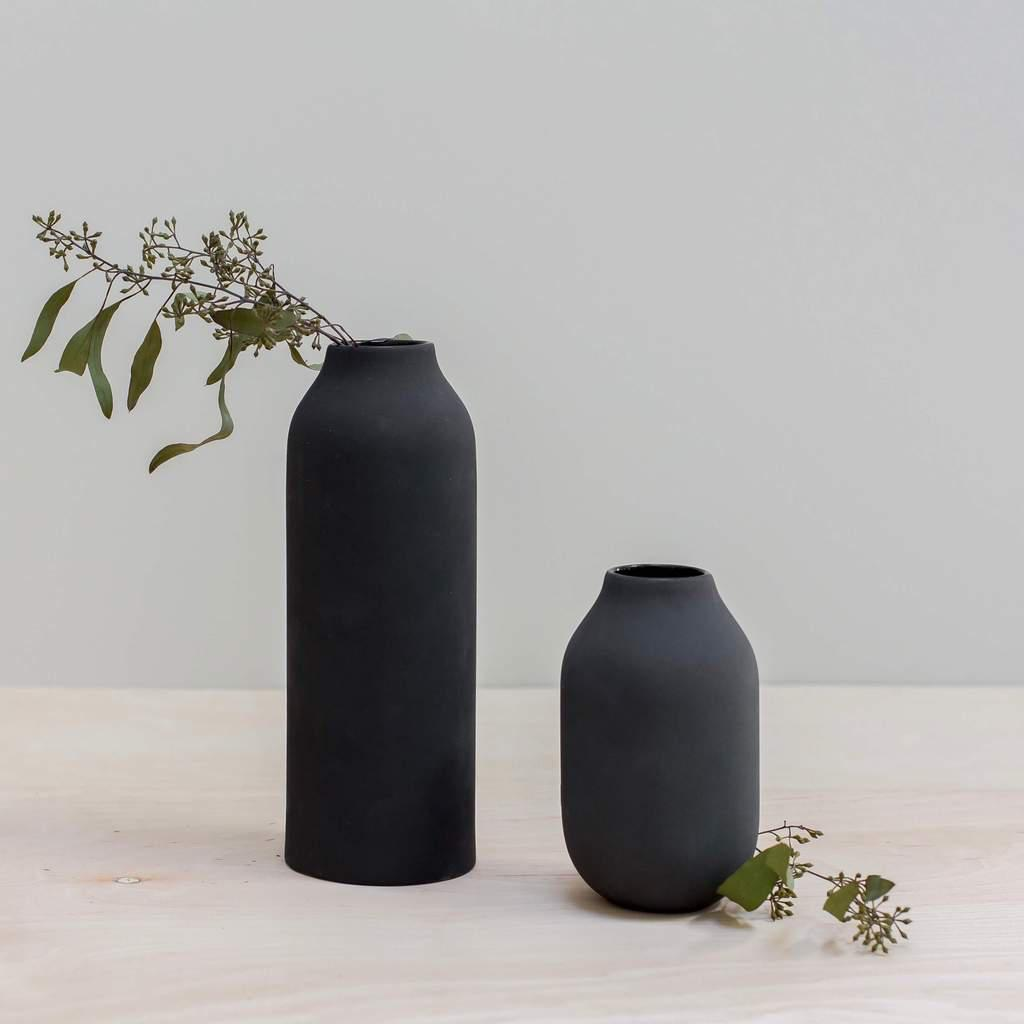

In [7]:
!wget https://cdn.shopify.com/s/files/1/0438/1069/products/TheCitizenry_HolidayTabletop_2018-9610_145d74eb-576f-47d1-b208-4813965c5fe3_1024x1024.jpg?v=1541514971 -O test.jpg
image_path = 'test.jpg'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])
  
image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)
Image.fromarray(np_image.astype(np.uint8)).save('test.jpg')
display.display(display.Image(image_path, width=1024))

np_image = np.zeros([height, width, 3],dtype=np.uint8)

# np_image = img.reshape(height, width, 3).astype(np.uint8)


## Create a Tensorflow session
Now let us create a Tensorflow session to run the inference. You can either connect to a TPU or a normal CPU backend.

In [0]:
use_tpu = False #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

# Load the pretrained model
Loading the COCO pretrained saved model from the public GCS bucket. 

In [10]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


## Perform instance segmentation and retrieve the predictions
Now let's run the inference and process the predictions from the model.


In [0]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

## Visualize the detection results
Time to check out the result!

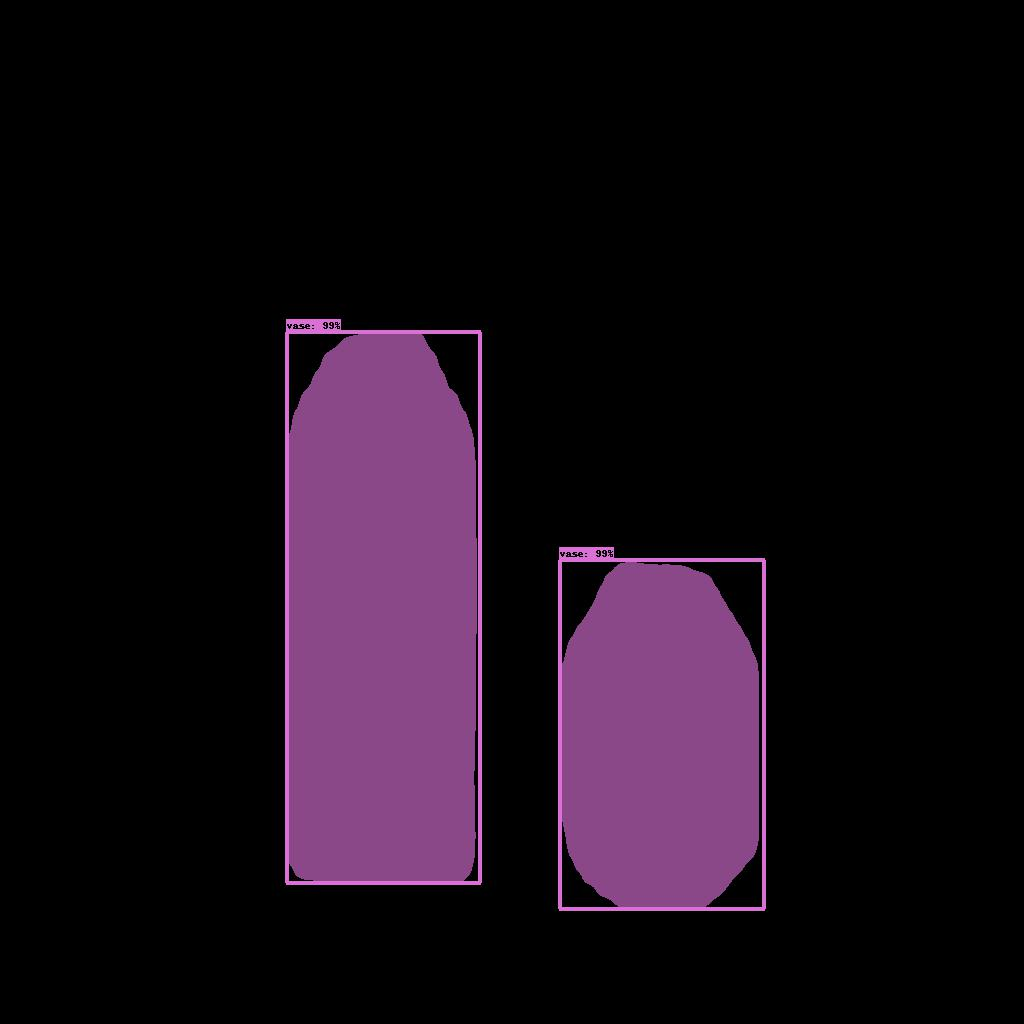

In [13]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.9    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

##separate the object from the background

In [0]:
gt = Image.open('test_results.jpg')
width, height = gt.size
gt = np.asanyarray(gt)

org = Image.open('test.jpg')
org = np.asanyarray(org)

In [0]:
bg = np.zeros([height, width, 3],dtype=np.uint8)
bg.fill(255)
ob = np.zeros([height, width, 3],dtype=np.uint8)
ob.fill(255)

for i in range(width):
    for j in range(height):
        if   gt[j][i][0] > 50:
            ob[j][i]=org[j][i]
        else:
            bg[j][i]=org[j][i]


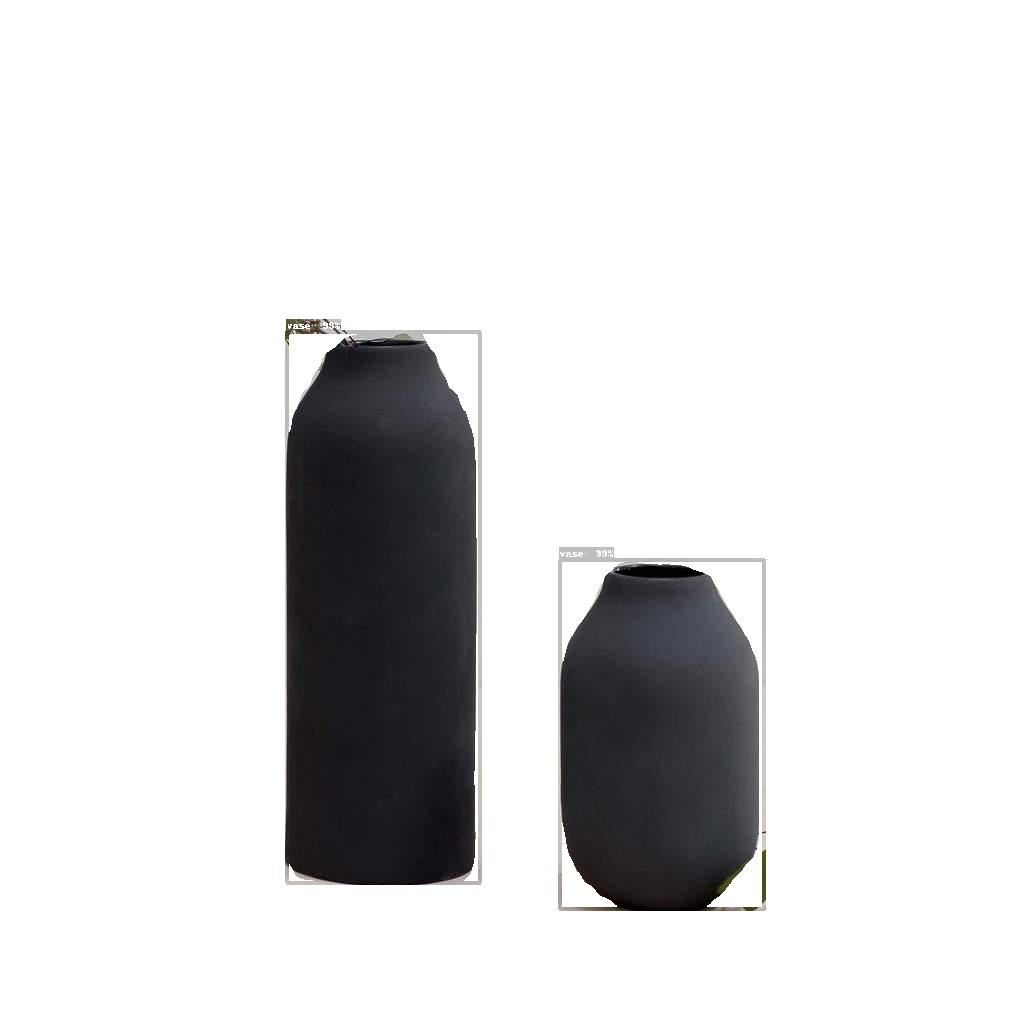

In [16]:
Image.fromarray(ob.astype(np.uint8)).save('ob.jpg')
display.display(display.Image('ob.jpg', width=1024))

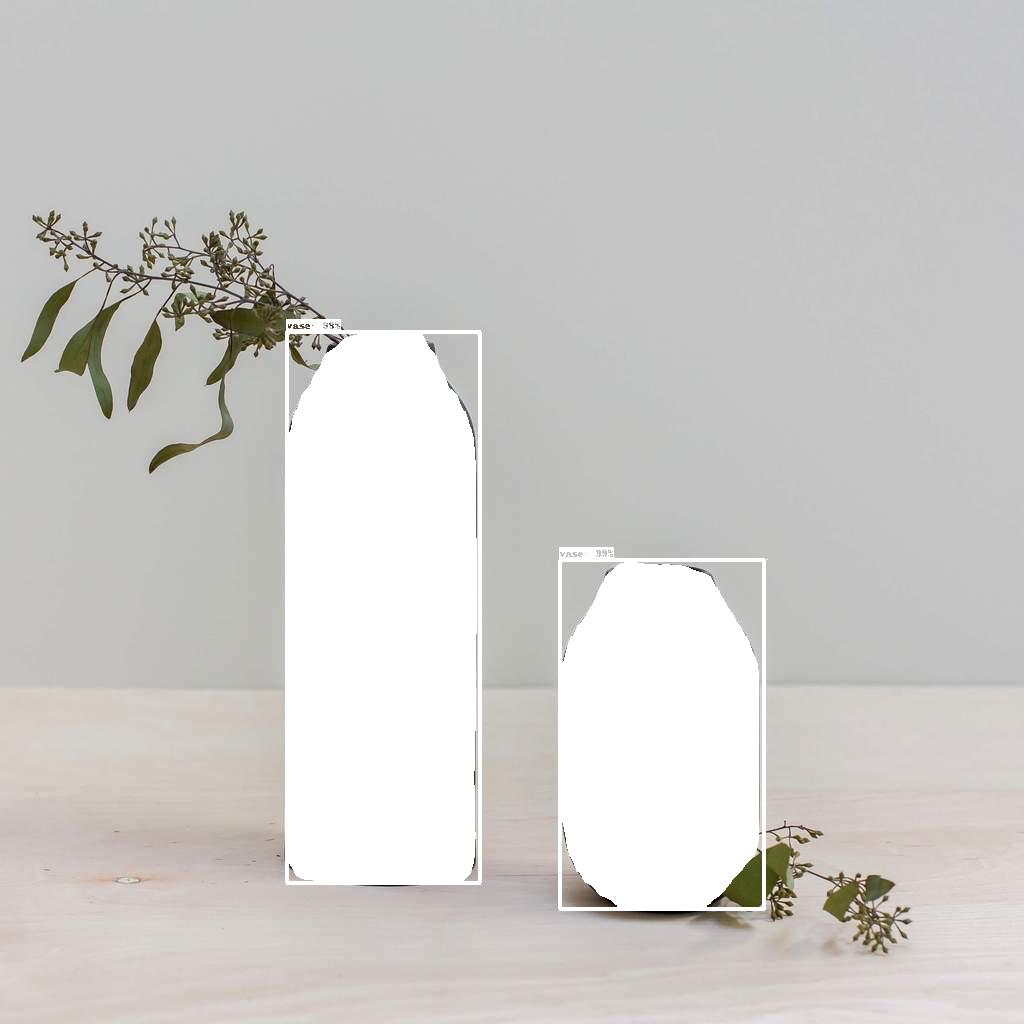

In [17]:
Image.fromarray(bg.astype(np.uint8)).save('bg.jpg')
display.display(display.Image('bg.jpg', width=1024))

In [23]:
dir_path = "Neural-Style-Transfer"
NETWORK = 'INetwork' + '.py'
# List all the arguments that can be supplied to Network.py
!python {dir_path}/{NETWORK} -h

# Image size
IMAGE_SIZE = 500

# Loss Weights
CONTENT_WEIGHT = 0.025
STYLE_WEIGHT = 1.0
STYLE_SCALE = 1.0
TOTAL_VARIATION_WEIGHT = 8.5e-5
CONTENT_LOSS_TYPE = 0

# Training arguments
NUM_ITERATIONS = 10
MODEL = 'vgg19'
RESCALE_IMAGE = 'false'
MAINTAIN_ASPECT_RATIO = 'false'  # Set to false if OOM occurs

# Transfer Arguments
CONTENT_LAYER = 'conv' + '5_2'  # only change the number 5_2 to something in a similar format
INITIALIZATION_IMAGE = 'content'
POOLING_TYPE = 'max'

# Extra arguments
PRESERVE_COLOR = 'false'
MIN_IMPROVEMENT = 0.0



Using TensorFlow backend.
usage: INetwork.py [-h] [--style_masks STYLE_MASKS [STYLE_MASKS ...]]
                   [--content_mask CONTENT_MASK] [--color_mask COLOR_MASK]
                   [--image_size IMG_SIZE] [--content_weight CONTENT_WEIGHT]
                   [--style_weight STYLE_WEIGHT [STYLE_WEIGHT ...]]
                   [--style_scale STYLE_SCALE]
                   [--total_variation_weight TV_WEIGHT] [--num_iter NUM_ITER]
                   [--model MODEL] [--content_loss_type CONTENT_LOSS_TYPE]
                   [--rescale_image RESCALE_IMAGE]
                   [--rescale_method RESCALE_METHOD]
                   [--maintain_aspect_ratio MAINTAIN_ASPECT_RATIO]
                   [--content_layer CONTENT_LAYER] [--init_image INIT_IMAGE]
                   [--pool_type POOL] [--preserve_color COLOR]
                   [--min_improvement MIN_IMPROVEMENT]
                   base ref [ref ...] res_prefix

Neural style transfer with Keras.

positional arguments:
  base     

In [0]:
import os

RESULT_DIR = "generated/"
RESULT_PREFIX = RESULT_DIR + "gen"
FINAL_IMAGE_PATH = RESULT_PREFIX + "_ob_at_iteration_%d.jpg" % (NUM_ITERATIONS)

if not os.path.exists(RESULT_DIR):
  os.makedirs(RESULT_DIR)

In [0]:

!python {dir_path}/{NETWORK} {'/content/ob.jpg'} {'/content/style1.jpg'} {RESULT_PREFIX} \
  --image_size {IMAGE_SIZE} --content_weight {CONTENT_WEIGHT} --style_weight \
  {STYLE_WEIGHT} --style_scale {STYLE_SCALE} --total_variation_weight \
  {TOTAL_VARIATION_WEIGHT} --content_loss_type {CONTENT_LOSS_TYPE} --num_iter \
  {NUM_ITERATIONS} --model {MODEL} --rescale_image {RESCALE_IMAGE} \
  --maintain_aspect_ratio {MAINTAIN_ASPECT_RATIO} --content_layer {CONTENT_LAYER} \
  --init_image {INITIALIZATION_IMAGE} --pool_type {POOLING_TYPE} --preserve_color \
  {PRESERVE_COLOR} --min_improvement {MIN_IMPROVEMENT}

Using TensorFlow backend.




80142336/80134624 [==============================] - 1s 0us/step



2020-01-25 07:30:46.191453: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2020-01-25 07:30:46.191659: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x606ce00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-01-25 07:30:46.191693: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-01-25 07:30:46.193736: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-01-25 07:30:46.307629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-01-25 07:30:46.308308: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x606cfc0 initializ

In [0]:
FINAL_IMAGE_PATH = RESULT_PREFIX + "_bg_at_iteration_%d.jpg" % (NUM_ITERATIONS)

In [22]:
!python {dir_path}/{NETWORK} {'/content/bg.jpg'} {'/content/style2.jpg'} {RESULT_PREFIX} \
  --image_size {IMAGE_SIZE} --content_weight {CONTENT_WEIGHT} --style_weight \
  {STYLE_WEIGHT} --style_scale {STYLE_SCALE} --total_variation_weight \
  {TOTAL_VARIATION_WEIGHT} --content_loss_type {CONTENT_LOSS_TYPE} --num_iter \
  {NUM_ITERATIONS} --model {MODEL} --rescale_image {RESCALE_IMAGE} \
  --maintain_aspect_ratio {MAINTAIN_ASPECT_RATIO} --content_layer {CONTENT_LAYER} \
  --init_image {INITIALIZATION_IMAGE} --pool_type {POOLING_TYPE} --preserve_color \
  {PRESERVE_COLOR} --min_improvement {MIN_IMPROVEMENT}

python3: can't open file 'Neural-Style-Transfer/INetwork.py': [Errno 2] No such file or directory


In [0]:
img = Image.open('art.jpg')
wpercent = (width/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((width,hsize), Image.ANTIALIAS)
img.save('sompic.jpg')

ob = Image.open('sompic.jpg')
ob = np.asanyarray(ob)

bg = Image.open('test.jpg')
bg = np.asanyarray(bg)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
final = np.zeros([height, width, 3],dtype=np.uint8)
new.fill(255)

for i in range(width):
    for j in range(height):
        if   gt[j][i][0] > 50:
            final[j][i]=ob[j][i]
        else:
            final[j][i]=bg[j][i]
            
Image.fromarray(final.astype(np.uint8)).save('final.jpg')
display.display(display.Image('final.jpg', width=1024))

NameError: ignored

# What's next

* Learn about [Cloud TPUs](https://cloud.google.com/tpu/docs) that Google designed and optimized specifically to speed up and scale up ML workloads for training and inference and to enable ML engineers and researchers to iterate more quickly.
* Explore the range of [Cloud TPU tutorials and Colabs](https://cloud.google.com/tpu/docs/tutorials) to find other examples that can be used when implementing your ML project.
* [Here's](https://cloud.google.com/tpu/docs/tutorials/mask-rcnn) a direct link to the Mask R-CNN tutorial.
